In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from datetime import datetime

%matplotlib inline

In [6]:
#read in data
df = pd.read_csv('takehome_user_engagement.csv')
users = pd.read_csv('takehome_users.csv', encoding = 'latin-1')

In [8]:
users.head()


,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


First of all we will use the engagement table to get a list of users that fall into the adopted  category.  Adopted users are those who have logged into the product on three separate days in at least one seven day period and not adopted users are those who did not meet this criterion.


In [31]:
from collections import OrderedDict

#Convert time_stamp column to type datetime
df['time_stamp'] = pd.to_datetime(df.time_stamp)

# use  floor for floor by days and then groupby with rolling by each 3 rows.
#datetimes are converted to unix times as numeric required

df['time_stamp'] = df['time_stamp'].dt.floor('d').astype(np.int64)

#sorting and remove duplicated days per users 
df = df.sort_values(['user_id', 'time_stamp']).drop_duplicates()

a = df.groupby('user_id')['time_stamp'].rolling(window=3)

days_bet= pd.to_timedelta((a.max()- a.min())).dt.days   # get number of days between 3rd login and 1st login.

adopt= list(OrderedDict.fromkeys(days_bet[days_bet<8].index.get_level_values('user_id')))



In [30]:
print('Number of Adopted Users : {}'. format(len(adopt)))

Number of Adopted Users : 1656


In [32]:
#create column called adopted in users table where if user is in adopt list adopted will be 1  and 0 otherwise.
users["adopted"] = np.where(users["object_id"].isin(adopt), 1, 0)

In [34]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0


What proportion of the users are adopted?

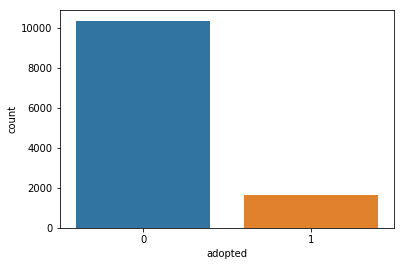

In [36]:

sns.countplot(data=users,
                  x ='adopted')

In [39]:
percent_adopted = (users['adopted'].value_counts()/len(users['adopted'])) *100
percent_adopted

0    86.2
1    13.8
Name: adopted, dtype: float64


Only 13.8% of the users are adopted. 

In [35]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
adopted                       12000 non-null int32
dtypes: float64(2), int32(1), int64(4), object(4)
memory usage: 984.5+ KB


Of the columns in the users table, two columns, last_session_creation_time and invited_by_user_id have only 8823 and 6417 observations indicating the presence of missing values.

To explore the predictive strength of each  feature on adopted/not adopted we will:
 1. Extract the email domain from the email column into a column called domain
 2. convert the last_session_creation_time to a date 
 3. change creation_time to  datetime  object


In [43]:
def domainsplit(x):
   try:
     return x.split("@")[1]
   except:
     return print("not a domain")

In [44]:
users["domain"] = users["email"].apply(lambda x: domainsplit(x))

In [51]:
users["last_session"]= pd.to_datetime(users['last_session_creation_time'], unit='ms')

In [53]:
users["creation_time"]=pd.to_datetime(users["creation_time"])

In [54]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 13 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null datetime64[ns]
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
adopted                       12000 non-null int32
domain                        12000 non-null object
last_session                  8823 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int32(1), int64(4), object(4)
memory usage: 1.1+ MB


In [55]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,domain,last_session
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0,yahoo.com,1970-01-17 04:22:18.810
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1,gustr.com,1970-01-17 03:50:37.504
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0,gustr.com,1970-01-16 18:48:54.892
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0,yahoo.com,1970-01-16 20:20:10.168
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0,yahoo.com,1970-01-16 17:27:29.660


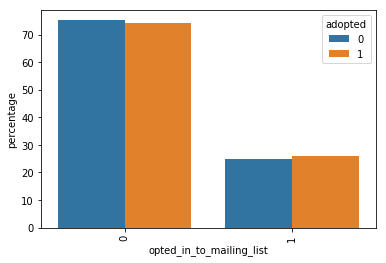

In [67]:
mailing_counts = (users.groupby(['adopted'])['opted_in_to_mailing_list']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('opted_in_to_mailing_list'))
p = sns.barplot(x='opted_in_to_mailing_list', y="percentage", hue="adopted", data=mailing_counts)


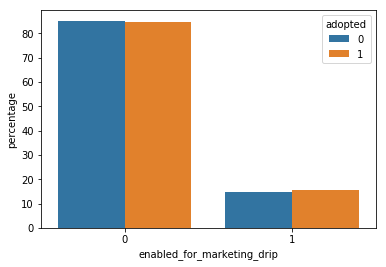

In [78]:


b   =(users.groupby(['adopted'])["enabled_for_marketing_drip"]
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values("enabled_for_marketing_drip"))
p = sns.barplot(x="enabled_for_marketing_drip", y="percentage", hue="adopted", data=b)


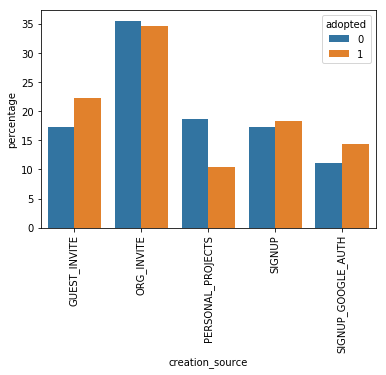

In [80]:
b   =(users.groupby(['adopted'])["creation_source"]
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values("creation_source"))
p = sns.barplot(x="creation_source", y="percentage", hue="adopted", data=b)
_ = plt.setp(p.get_xticklabels(), rotation=90)  # Rotate labels

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'RangeIndex'